# 4.0 - Detailed EDA on Final Features

_by Michael Joshua Vargas_

This notebook performs detailed Exploratory Data Analysis (EDA) on the final set of features after feature selection. It categorizes features and generates visualizations with fraud-related interpretations.

In [1]:
%load_ext autoreload
%autoreload
%reload_ext autoreload

### Import relevant libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from pathlib import Path
import sys
import io

import os

import warnings

# Suppress all warnings for cleaner output in notebooks
warnings.filterwarnings('ignore')

In [3]:
# Determine the project root dynamically
project_root = Path(os.getcwd()).parent

if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Import from config.py
from bank_fraud.config import REPORTS_FIGURES_DIR, REFERENCES_DIR

### Load the dataset

In [4]:
def parse_iv_details_file(file_path):
    """
    Parses the custom block-based IV details file format.
    """
    with open(file_path, 'r') as f:
        content = f.read()
        blocks = [b.strip() for b in content.split('\n\n') if b.strip()]

    all_dfs = []
    for block in blocks:
        lines = block.split('\n')
        header_line = lines[0]
        # The feature name is the first item in the header
        feature_name = header_line.split('\t')[0]
        
        # The rest of the header
        header = header_line.split('\t')
        
        data_lines = lines[1:]
        
        # Reconstruct the block as a string for pandas to read
        data_io = io.StringIO('\n'.join(data_lines))
        
        # Read the data part of the block
        df_block = pd.read_csv(data_io, sep='\t', header=None, names=header)
        
        # The first column of the data is the 'Category'
        df_block.rename(columns={feature_name: 'Category'}, inplace=True)
        
        # Add the feature name as a new column
        df_block['feature'] = feature_name
        all_dfs.append(df_block)

    if not all_dfs:
        return pd.DataFrame()

    # Concatenate all feature blocks into a single DataFrame
    final_df = pd.concat(all_dfs, ignore_index=True)
    
    # Set the feature name as the index
    final_df.set_index('feature', inplace=True)
    return final_df

In [5]:
# Load IV details from the processed Excel file
PROCESSED_IV_PATH = REFERENCES_DIR / 'iv_details_processed.xlsx'

In [6]:
# Load the prepared data from the previous step (after feature selection)
SELECTED_FEATURES_PATH = project_root / 'data' / 'interim' / '3.0_selected_features.parquet'
df = pd.read_parquet(SELECTED_FEATURES_PATH).copy()

print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns.")

Dataset loaded with 493189 rows and 65 columns.


### Feature Categorization for Detailed EDA

Based on the feature selection process, a refined subset of features has been chosen for detailed Exploratory Data Analysis (EDA).
These features are categorized into five distinct types to facilitate a structured and insightful analysis of fraud patterns.
Each category groups related features, allowing for a more focused examination of their predictive power and behavioral characteristics.

In [7]:
# Define feature categories
FEATURE_CATEGORIES = {
    "Profile Traits": [
        "card_type",
        "acc_mgmt_channel",
        "orig_os",
        "change_email_occurence",
        "change_mob_num_occurence"
    ],
    "Transaction Size and Frequency": [
        "amount_INSTAPAY_IN",
        "amount_INSTAPAY_OUT",
        "count_total_in",
        "count_INSTAPAY_OUT"
    ],
    "Network Behaviors": [
        "num_unique_destination_accounts",
        "repeat_counterparty_ratio_out",
        "num_unique_source_names",
        "repeat_counterparty_ratio_in"
    ],
    "Time-Based Behaviors": [
        "night_txn_count",
        "weekend_txn_count",
        "hour_entropy",
        "max_txn_sessions_per_day_3min"
    ],
    "Fund Flow Patterns": [
        "txn_velocity_30d",
        "txn_count_day_volatility_30d"
    ]
}

In [8]:
def plot_feature_distribution(feature_name, category_name, plot_dir, title=""):
    """
    Generates a grouped vertical bar plot showing the distribution of PercentBad and PercentGood
    for each category/bin of a given feature.
    Includes the total Information Value (IV) in the title.

    Args:
        feature_name (str): The name of the feature to plot.
        category_name (str): The broad category the feature belongs to.
        plot_dir (Path): The directory where the plot image will be saved.
        title (str, optional): A textual information to be displayed at the top of the plot.
    """
    try:
        # Construct the path to the individual CSV file for the feature
        feature_iv_path = REFERENCES_DIR / 'iv_details' / f'{feature_name}_iv_details.csv'
        feature_data = pd.read_csv(feature_iv_path)
    except FileNotFoundError:
        print(f"Error: IV details file not found for '{feature_name}' at {feature_iv_path}.")
        return

    # Exclude the 'Grand Total' row for plotting
    plot_data = feature_data[feature_data['Category'] != 'Grand Total'].copy()

    # Get the total IV from the 'Grand Total' row for this feature
    try:
        total_iv = feature_data[feature_data['Category'] == 'Grand Total']['IV'].iloc[0]
    except IndexError:
        total_iv = plot_data['IV'].sum() # Fallback if Grand Total is missing

    # Ensure numerical columns are numeric
    plot_data['Fraud'] = pd.to_numeric(plot_data['PercentBad'])
    plot_data['Non_Fraud'] = pd.to_numeric(plot_data['PercentGood'])

    # Define colors
    HIGHLIGHT_FRAUD_COLOR = "#e0004e"
    MUTED_NON_FRAUD_COLOR = "#cccccc"

    # Create a DataFrame for plotting grouped bars
    plot_df = plot_data[['Category', 'Fraud', 'Non_Fraud']].set_index('Category')

    fig, ax = plt.subplots(figsize=(12, 7))
    fig.patch.set_facecolor('white') # Set figure background to white
    ax.set_facecolor('white') # Set axes background to white

    # Set bar width and positions
    bar_width = 0.35
    ind = np.arange(len(plot_df.index))

    # Plotting bars using Fraud and Non_Fraud, multiplied by 100 for percentage scale
    rects1 = ax.bar(ind - bar_width/2, plot_df['Fraud'] * 100, bar_width, label='Fraud', color=HIGHLIGHT_FRAUD_COLOR)
    rects2 = ax.bar(ind + bar_width/2, plot_df['Non_Fraud'] * 100, bar_width, label='Non_Fraud', color=MUTED_NON_FRAUD_COLOR)

    # Add percentages to bars
    ax.bar_label(rects1, padding=5, fmt='%.1f%%', fontsize=8)
    ax.bar_label(rects2, padding=5, fmt='%.1f%%', fontsize=8)

    # Remove chart junk (spines) and make remaining spines less prominent
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('white')
    ax.spines['bottom'].set_color('white')

    ax.set_xticks(ind)
    ax.set_xticklabels(plot_df.index, ha="center", fontsize=9) # Adjusted fontsize
    ax.set_title(f'{title}\nTotal IV: {total_iv:.4f}', fontsize=16, fontweight='bold') # Adjusted fontsize
    ax.set_xlabel(feature_name, fontsize=12)
    ax.tick_params(axis='y', length=0) # Remove y-axis ticks
    ax.set_yticklabels([]) # Remove y-axis labels
    ax.axhline(0, color='lightgray', linewidth=0.8) # Add a subtle horizontal line at 0%
    
    ax.grid(False) # Remove all gridlines
    ax.legend(title='Fraud Status', fontsize=10, title_fontsize=12, frameon=False) # Adjusted fontsize and removed frame
    plt.tight_layout(rect=[0, 0.1, 1, 1])

    # Save the plot
    output_filename = plot_dir / f'4.0_{feature_name}_fraud_distribution.png'
    plt.savefig(output_filename, bbox_inches='tight')
    print(f"Plot saved to: {output_filename.relative_to(project_root)}")
    plt.show()
    plt.close()

### Main EDA Sections

#### Profile Traits

**Which Profile Traits Are Most Predictive of Fraud?**

##### Card Type

Plot saved to: reports\figures\4.0_card_type_fraud_distribution.png


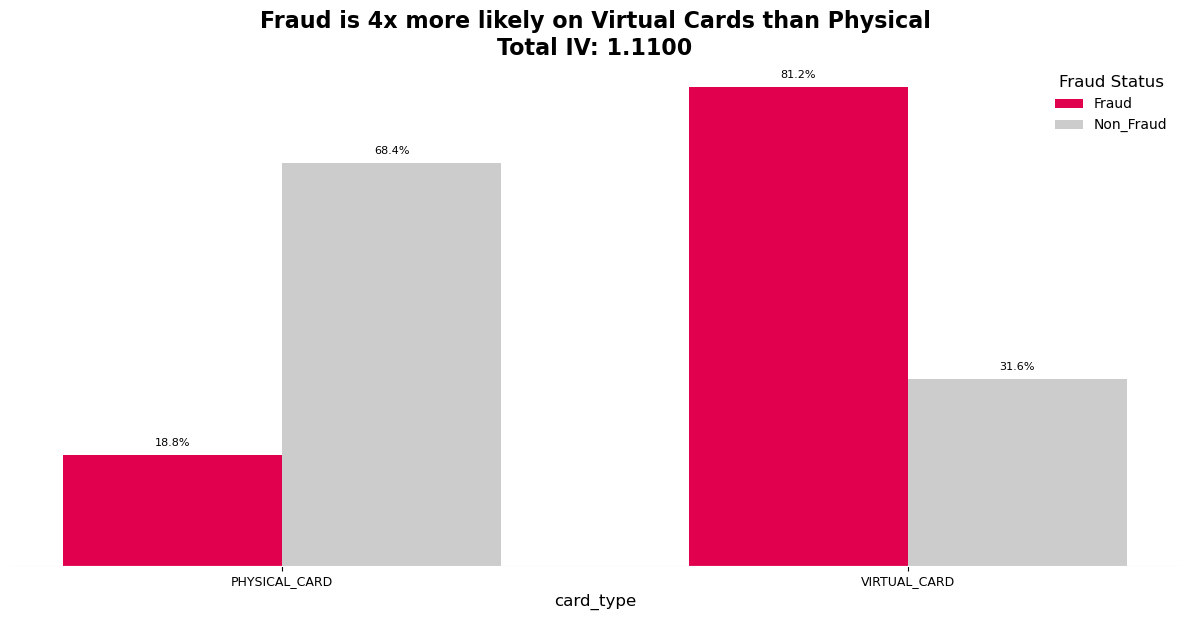

In [9]:
feature = "card_type"
category = "Profile Traits"
plot_feature_distribution(feature, category, REPORTS_FIGURES_DIR,
                title="Fraud is 4x more likely on Virtual Cards than Physical")

##### Account Channel

Plot saved to: reports\figures\4.0_acc_mgmt_channel_fraud_distribution.png


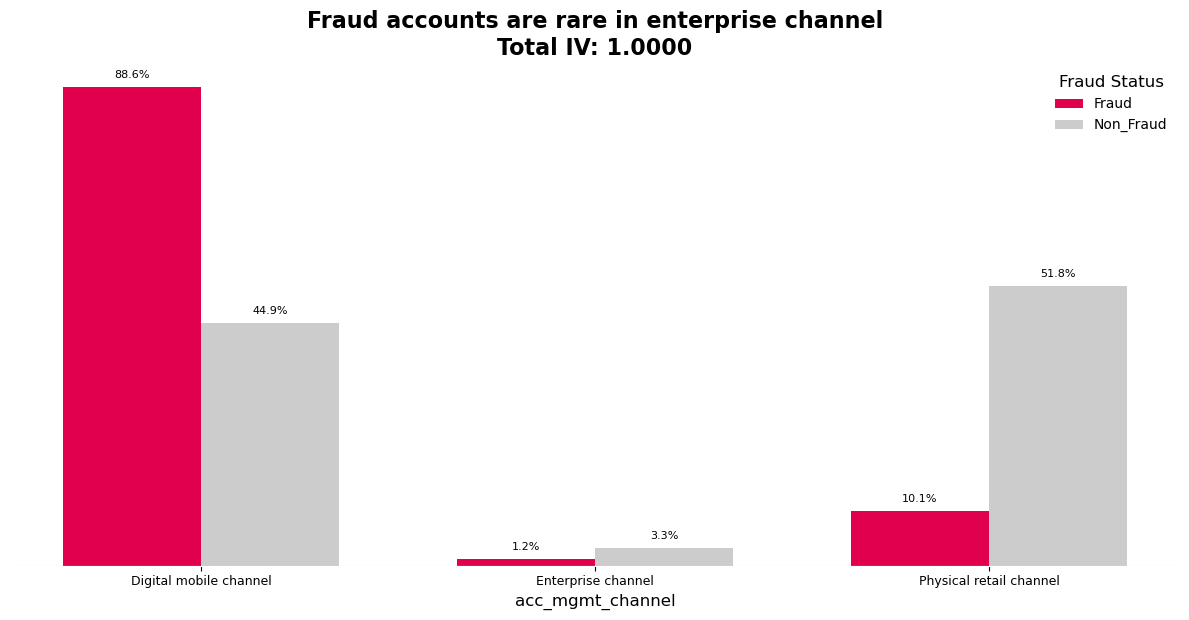

In [10]:
feature = "acc_mgmt_channel"
category = "Profile Traits"
plot_feature_distribution(feature, category, REPORTS_FIGURES_DIR,
                title="Fraud accounts are rare in enterprise channel")

##### Phone OS

Plot saved to: reports\figures\4.0_orig_os_fraud_distribution.png


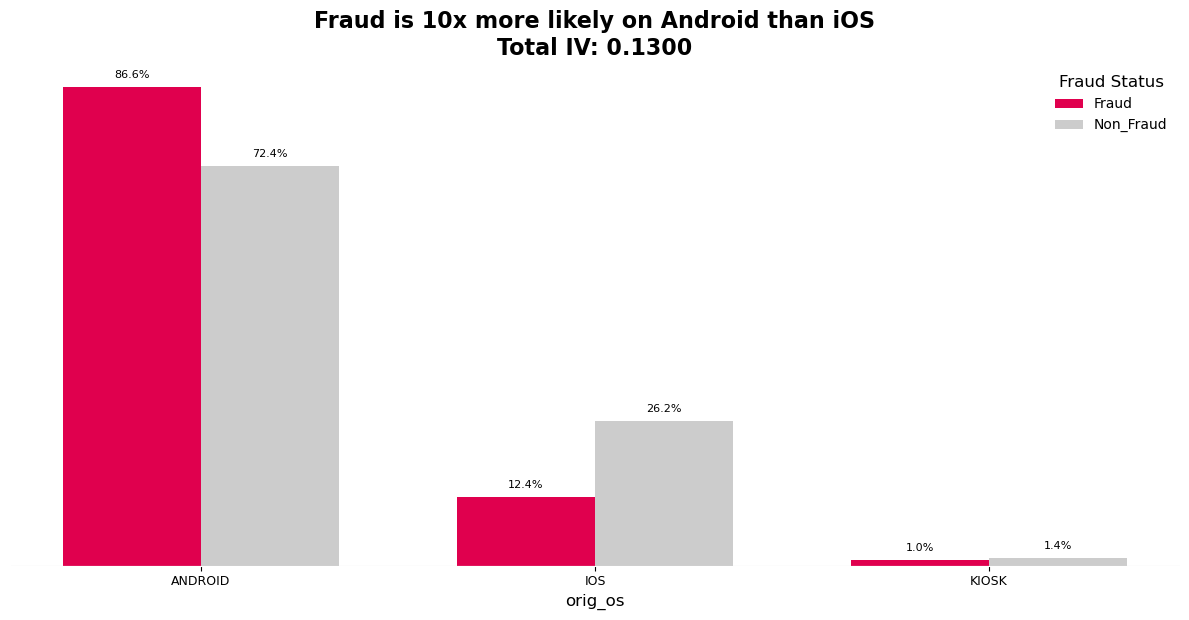

In [11]:
feature = "orig_os"
category = "Profile Traits"
plot_feature_distribution(feature, category, REPORTS_FIGURES_DIR,
                title="Fraud is 10x more likely on Android than iOS")

##### Email Change

Plot saved to: reports\figures\4.0_change_email_occurence_fraud_distribution.png


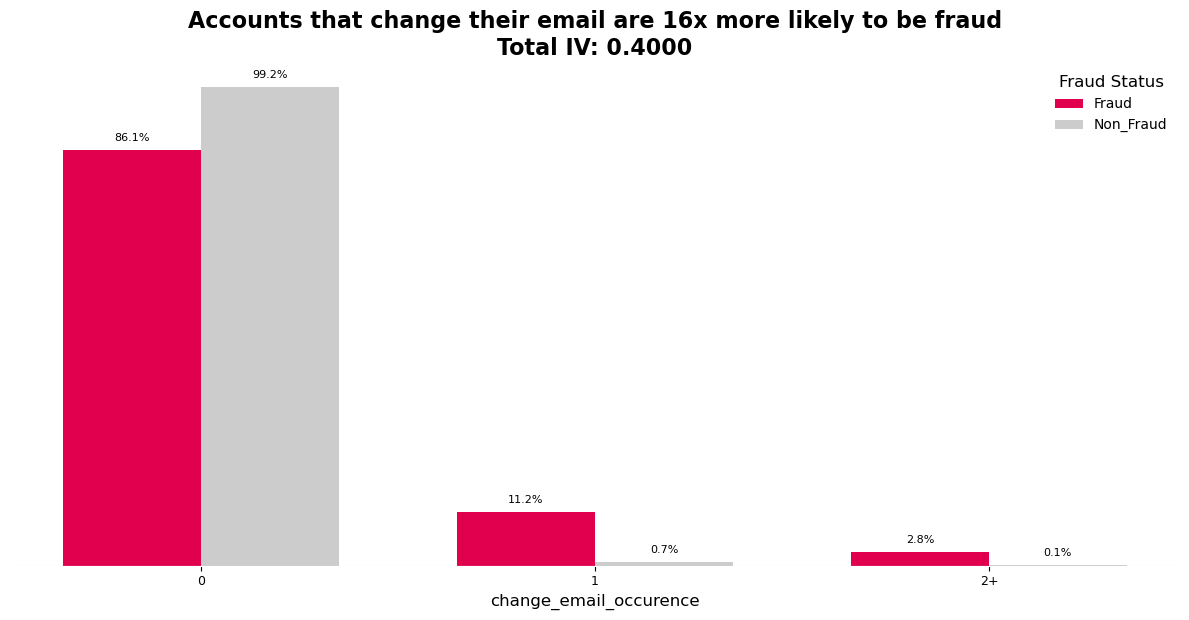

In [12]:
feature = "change_email_occurence"
category = "Profile Traits"
plot_feature_distribution(feature, category, REPORTS_FIGURES_DIR,
                title="Accounts that change their email are 16x more likely to be fraud")

##### Mobile Number Change

Plot saved to: reports\figures\4.0_change_mob_num_occurence_fraud_distribution.png


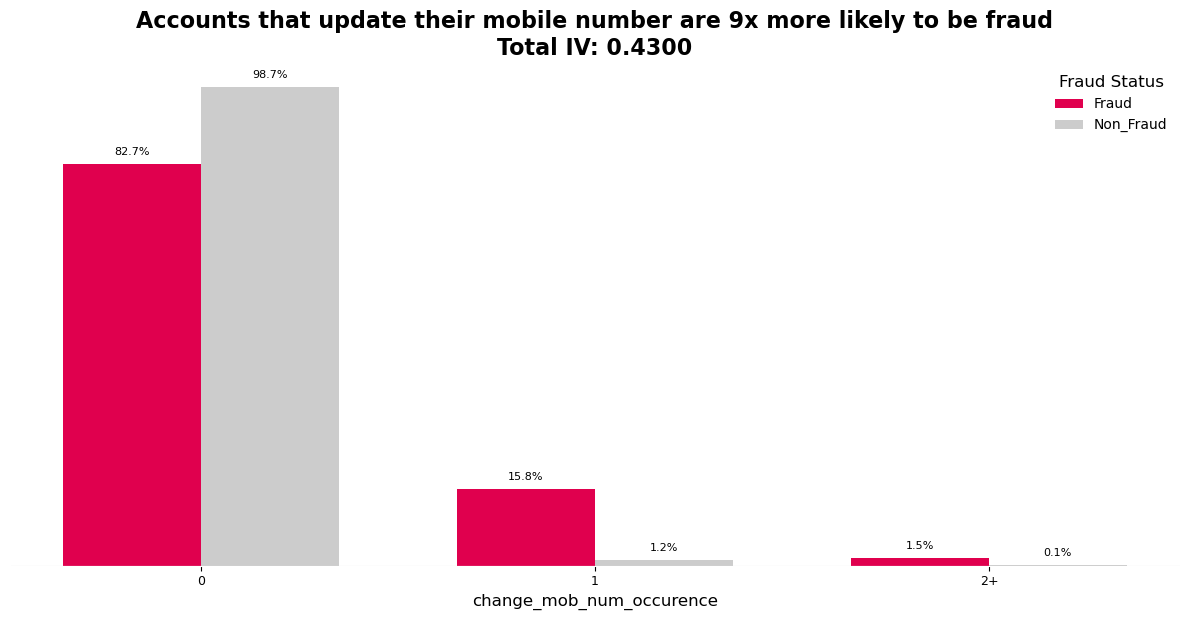

In [13]:
feature = "change_mob_num_occurence"
category = "Profile Traits"
plot_feature_distribution(feature, category, REPORTS_FIGURES_DIR,
                title="Accounts that update their mobile number are 9x more likely to be fraud")

#### Transaction Size and Frequency

**Do Transaction Size and Frequency Reveal Fraud?**

##### Total Amount In

Plot saved to: reports\figures\4.0_amount_INSTAPAY_IN_fraud_distribution.png


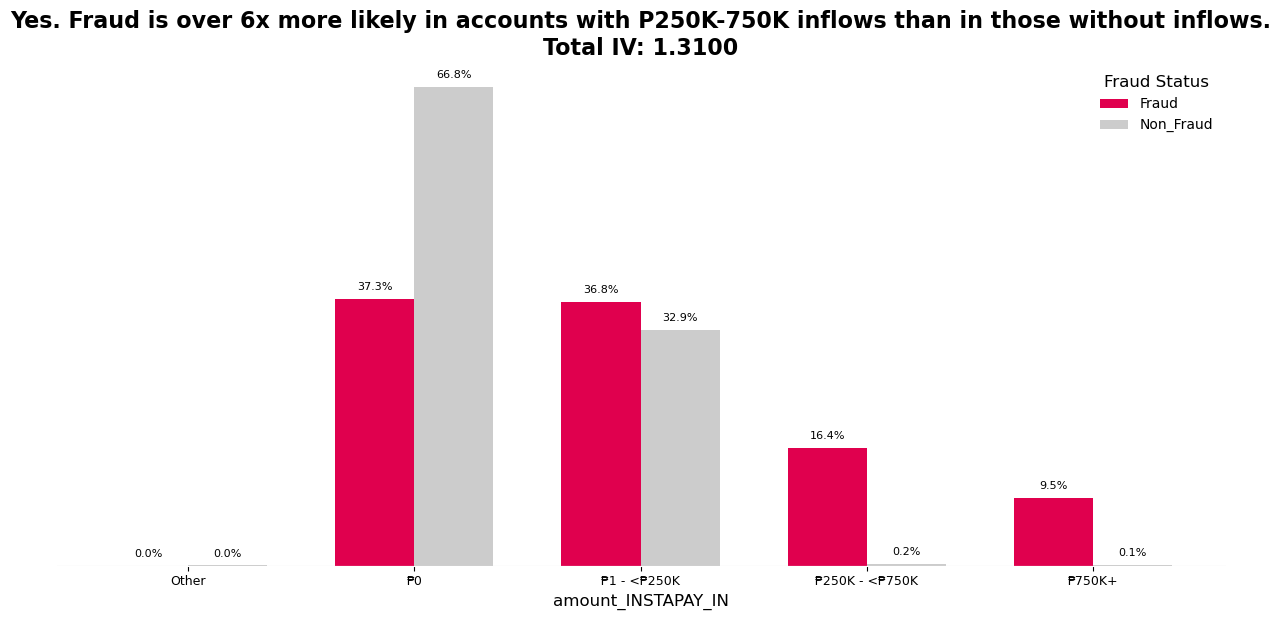

In [14]:
feature = "amount_INSTAPAY_IN"
category = "Transaction Size and Frequency"
plot_feature_distribution(feature, category, REPORTS_FIGURES_DIR,
                title="Yes. Fraud is over 6x more likely in accounts with P250K-750K inflows than in those without inflows.")

##### Total Amount Out

Plot saved to: reports\figures\4.0_amount_INSTAPAY_OUT_fraud_distribution.png


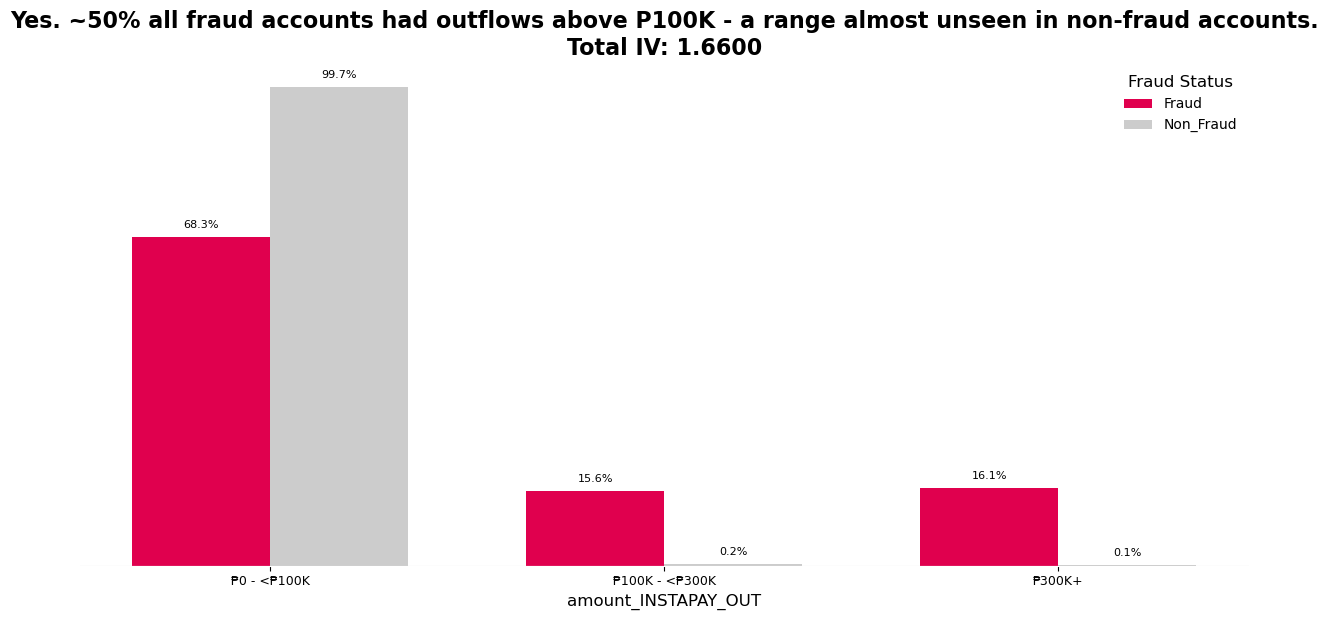

In [15]:
feature = "amount_INSTAPAY_OUT"
category = "Transaction Size and Frequency"
plot_feature_distribution(feature, category, REPORTS_FIGURES_DIR,
                title="Yes. ~50% all fraud accounts had outflows above P100K - a range almost unseen in non-fraud accounts.")

##### Total Count In

Plot saved to: reports\figures\4.0_count_total_in_fraud_distribution.png


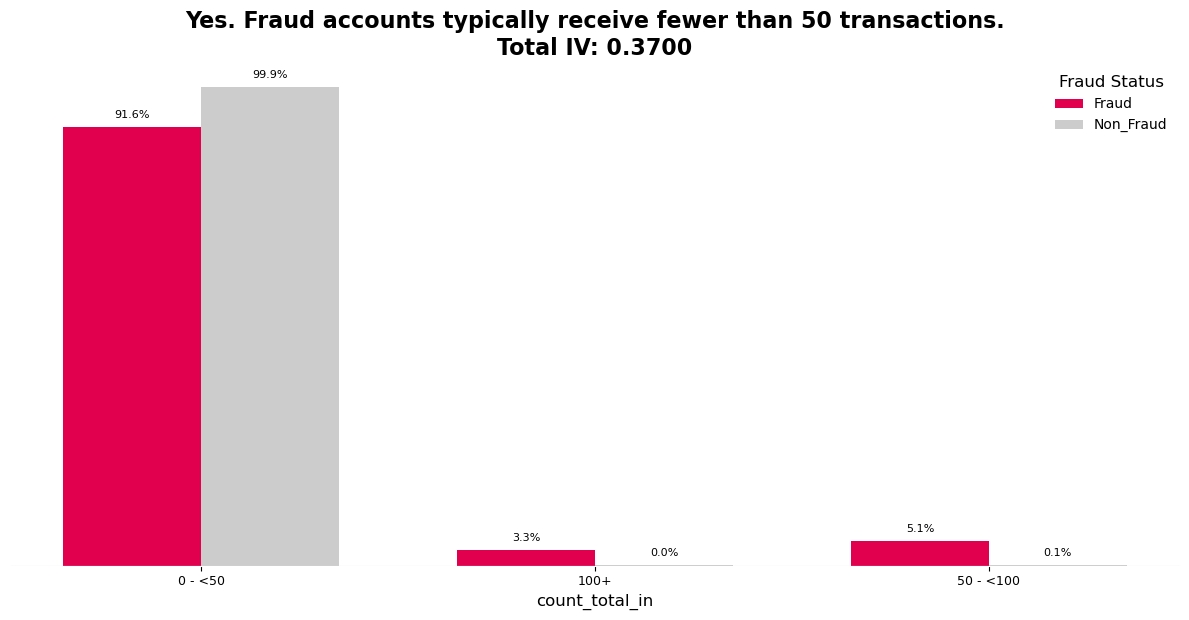

In [16]:
feature = "count_total_in"
category = "Transaction Size and Frequency"
plot_feature_distribution(feature, category, REPORTS_FIGURES_DIR,
                title="Yes. Fraud accounts typically receive fewer than 50 transactions.")

##### Total Amount Out

Plot saved to: reports\figures\4.0_count_INSTAPAY_OUT_fraud_distribution.png


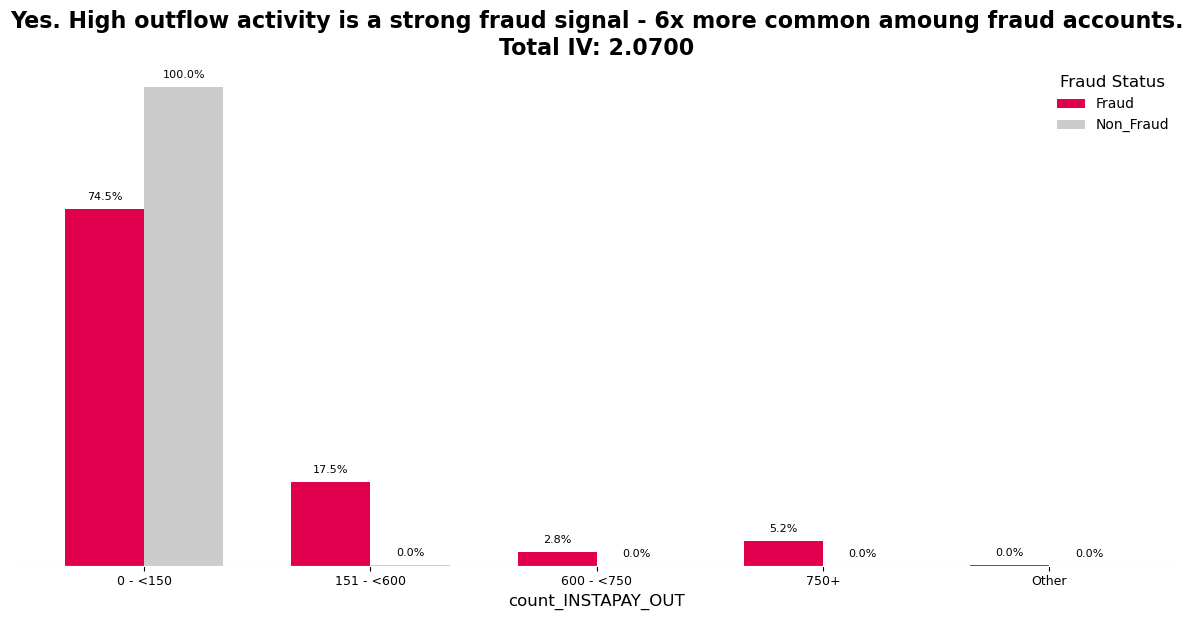

In [17]:
feature = "count_INSTAPAY_OUT"
category = "Transaction Size and Frequency"
plot_feature_distribution(feature, category, REPORTS_FIGURES_DIR,
                title="Yes. High outflow activity is a strong fraud signal - 6x more common amoung fraud accounts.")

#### Network Behaviors

**Do Network Behaviors Help Identify Fraud?**

##### Unique Destinations

Plot saved to: reports\figures\4.0_num_unique_destination_accounts_fraud_distribution.png


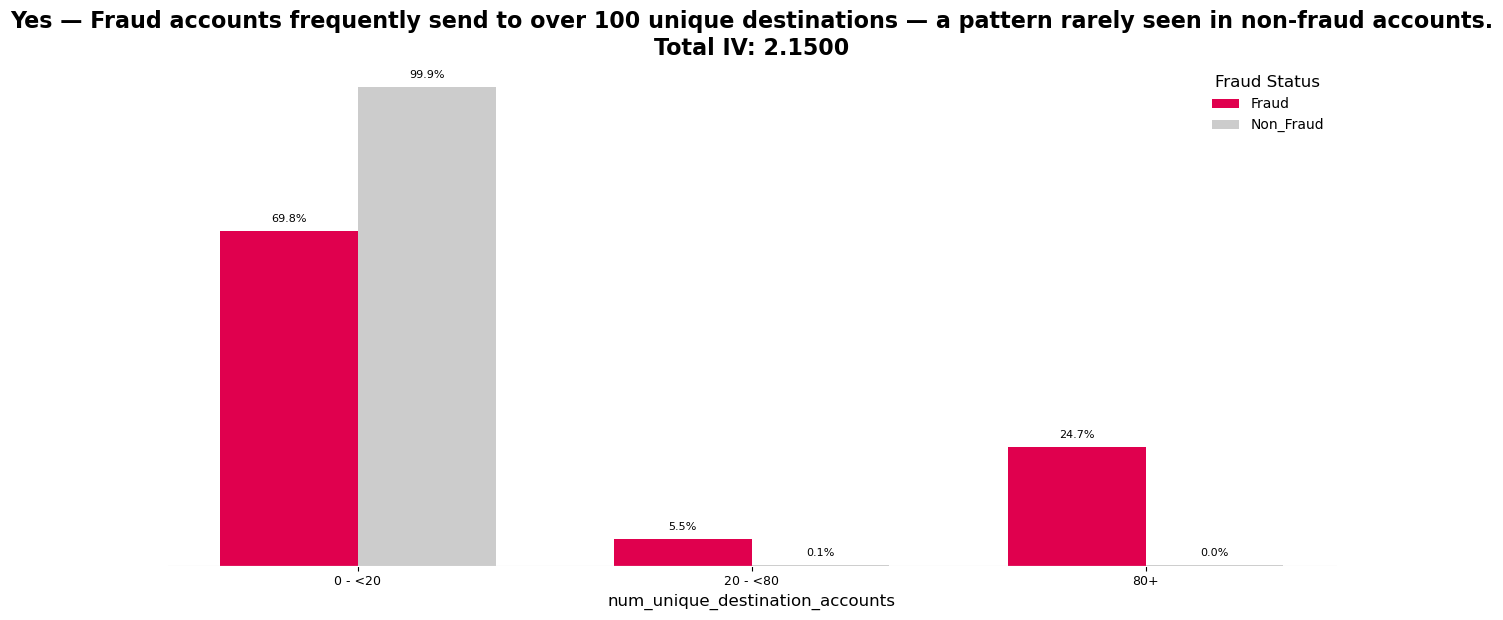

In [18]:
feature = "num_unique_destination_accounts"
category = "Network Behaviors"
plot_feature_distribution(feature, category, REPORTS_FIGURES_DIR,
                title="Yes — Fraud accounts frequently send to over 100 unique destinations — a pattern rarely seen in non-fraud accounts.")

##### Repeat Destinations Ratio

Plot saved to: reports\figures\4.0_repeat_counterparty_ratio_out_fraud_distribution.png


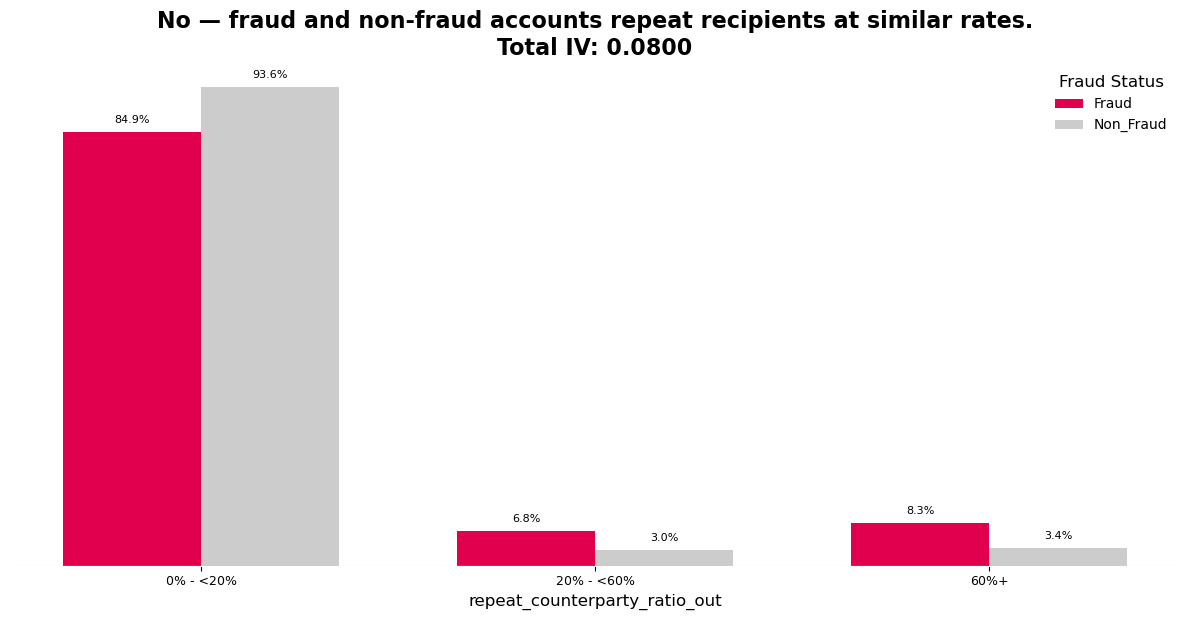

In [19]:
feature = "repeat_counterparty_ratio_out"
category = "Network Behaviors"
plot_feature_distribution(feature, category, REPORTS_FIGURES_DIR,
                title="No — fraud and non-fraud accounts repeat recipients at similar rates.")

##### Unique Source

Plot saved to: reports\figures\4.0_num_unique_source_accounts_fraud_distribution.png


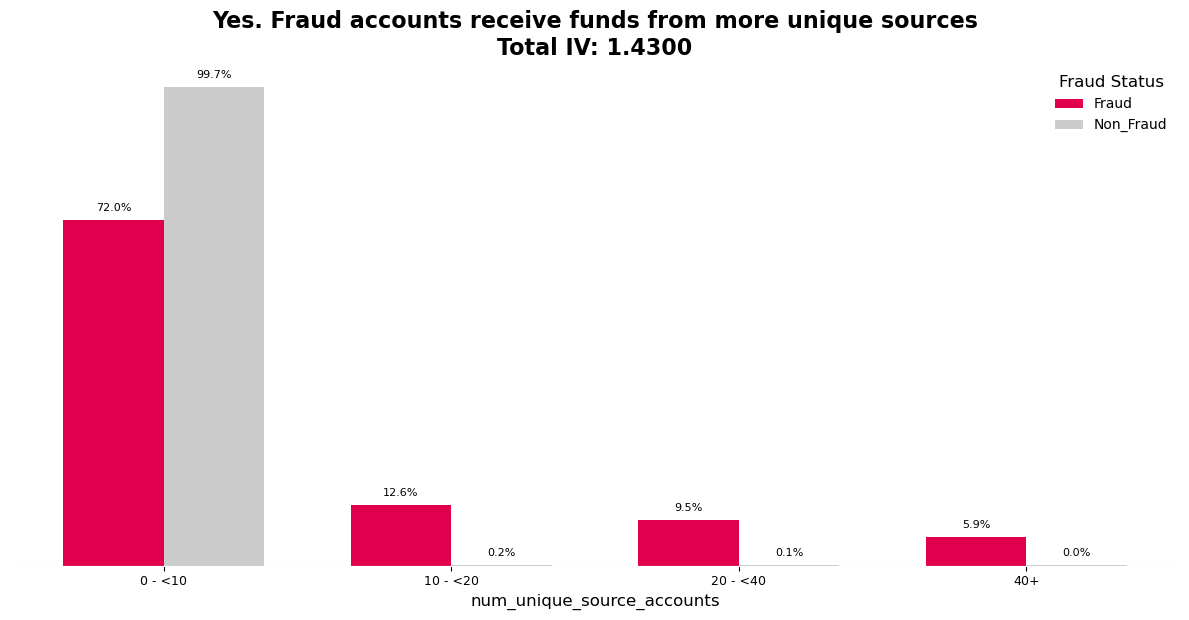

In [20]:
feature = "num_unique_source_accounts"
category = "Network Behaviors"
plot_feature_distribution(feature, category, REPORTS_FIGURES_DIR,
                title="Yes. Fraud accounts receive funds from more unique sources")

##### Repeat Source Ration

Plot saved to: reports\figures\4.0_repeat_counterparty_ratio_in_fraud_distribution.png


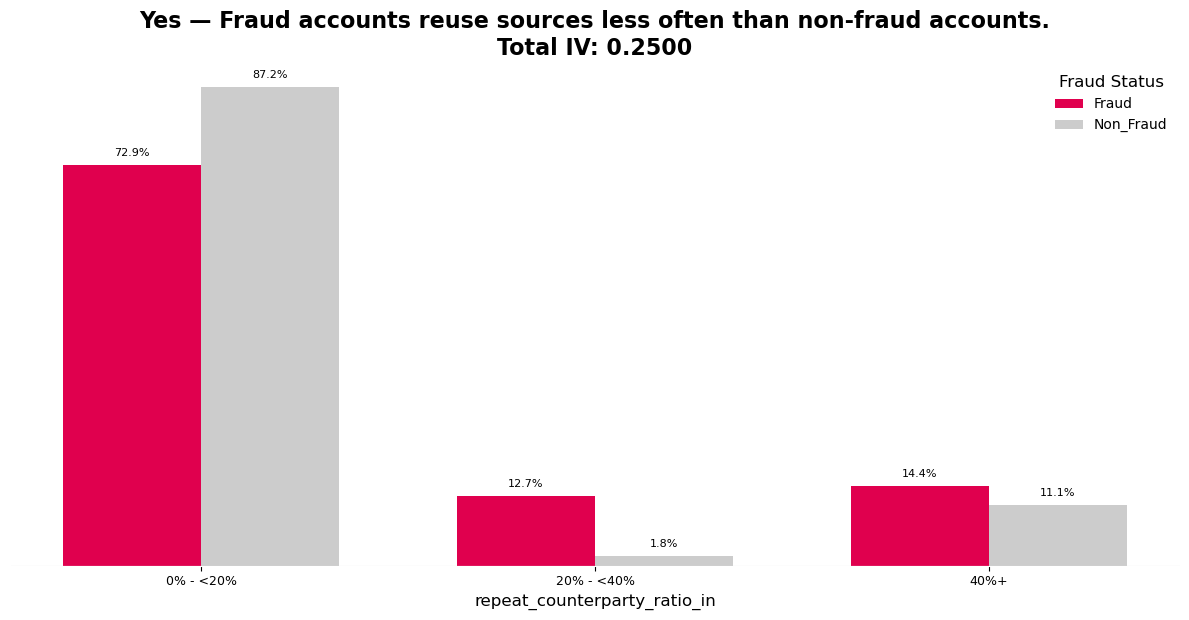

In [21]:
feature = "repeat_counterparty_ratio_in"
category = "Network Behaviors"
plot_feature_distribution(feature, category, REPORTS_FIGURES_DIR,
                title="Yes — Fraud accounts reuse sources less often than non-fraud accounts.")

#### Time-Based Behaviors

**Do Time-Based Behaviors Help Detect Fraud?**

##### Night Transactions

Plot saved to: reports\figures\4.0_night_txn_count_fraud_distribution.png


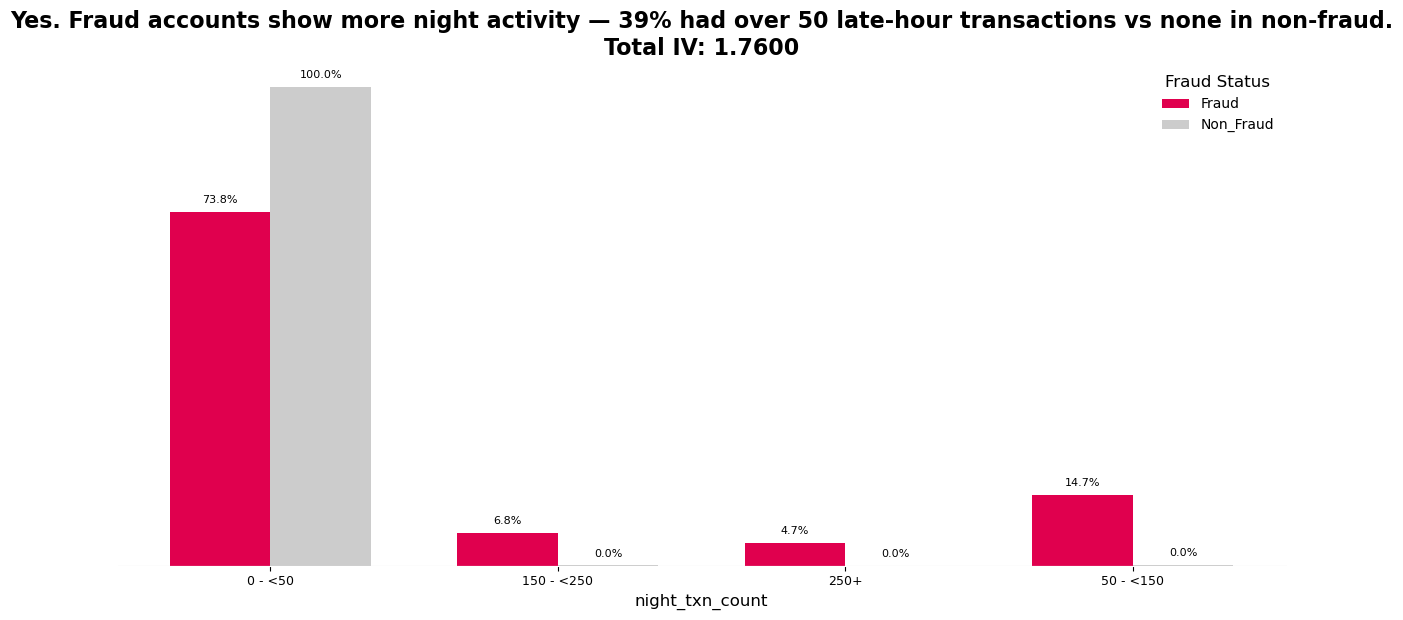

In [22]:
feature = "night_txn_count"
category = "Time-Based Behaviors"
plot_feature_distribution(feature, category, REPORTS_FIGURES_DIR,
                title="Yes. Fraud accounts show more night activity — 39% had over 50 late-hour transactions vs none in non-fraud.")

##### Weekend Transactions

Plot saved to: reports\figures\4.0_weekend_txn_count_fraud_distribution.png


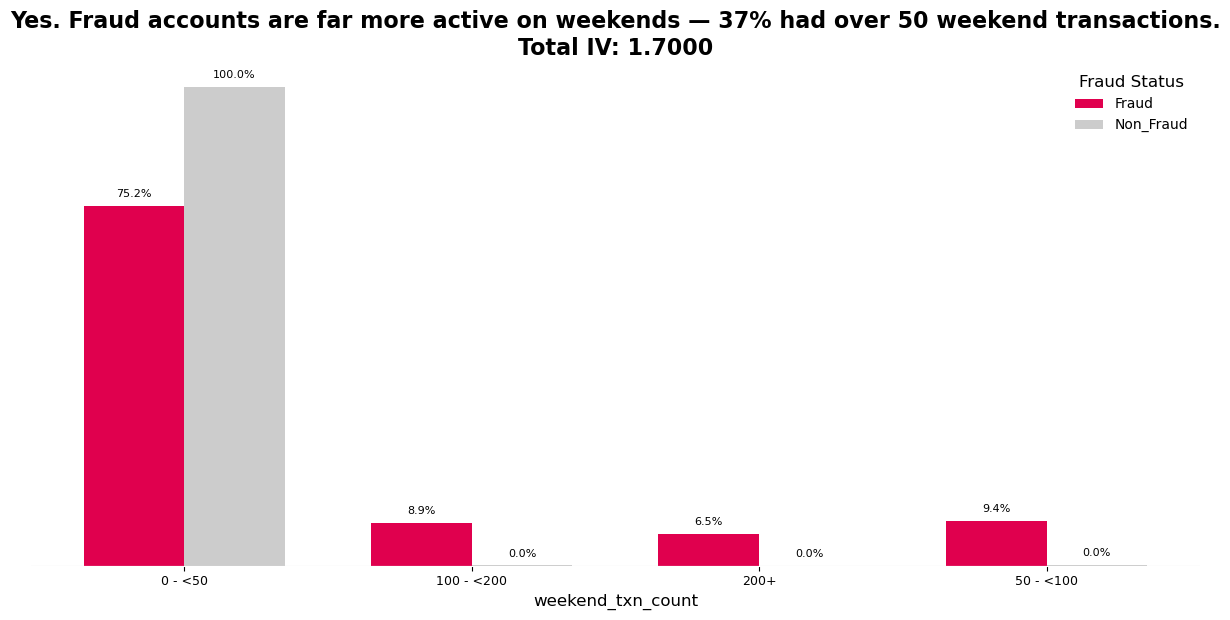

In [23]:
feature = "weekend_txn_count"
category = "Time-Based Behaviors"
plot_feature_distribution(feature, category, REPORTS_FIGURES_DIR,
                title="Yes. Fraud accounts are far more active on weekends — 37% had over 50 weekend transactions.")

##### Hour Entropy

Plot saved to: reports\figures\4.0_hour_entropy_fraud_distribution.png


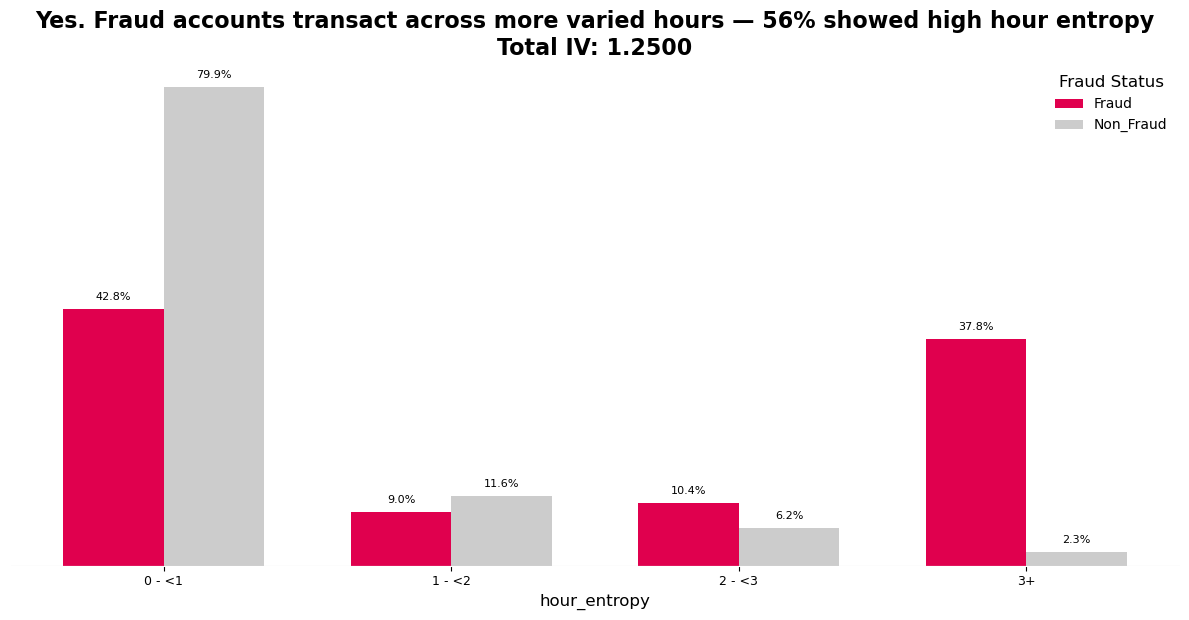

In [24]:
feature = "hour_entropy"
category = "Time-Based Behaviors"
plot_feature_distribution(feature, category, REPORTS_FIGURES_DIR,
                title="Yes. Fraud accounts transact across more varied hours — 56% showed high hour entropy")

##### 3-min Bursts

Plot saved to: reports\figures\4.0_max_txn_sessions_per_day_3min_fraud_distribution.png


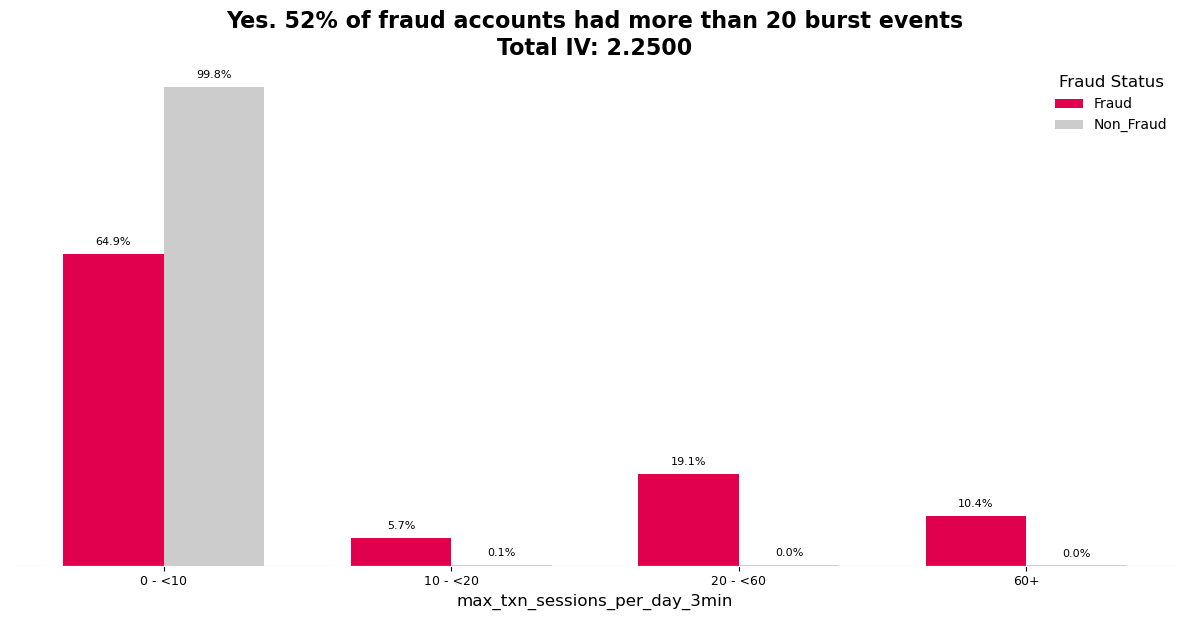

In [25]:
feature = "max_txn_sessions_per_day_3min"
category = "Time-Based Behaviors"
plot_feature_distribution(feature, category, REPORTS_FIGURES_DIR,
                title="Yes. 52% of fraud accounts had more than 20 burst events")

#### Fund Flow Patterns

**Can Fund Flow Patterns Reveal Fraud?**

##### Transaction Velocity

Plot saved to: reports\figures\4.0_txn_velocity_30d_fraud_distribution.png


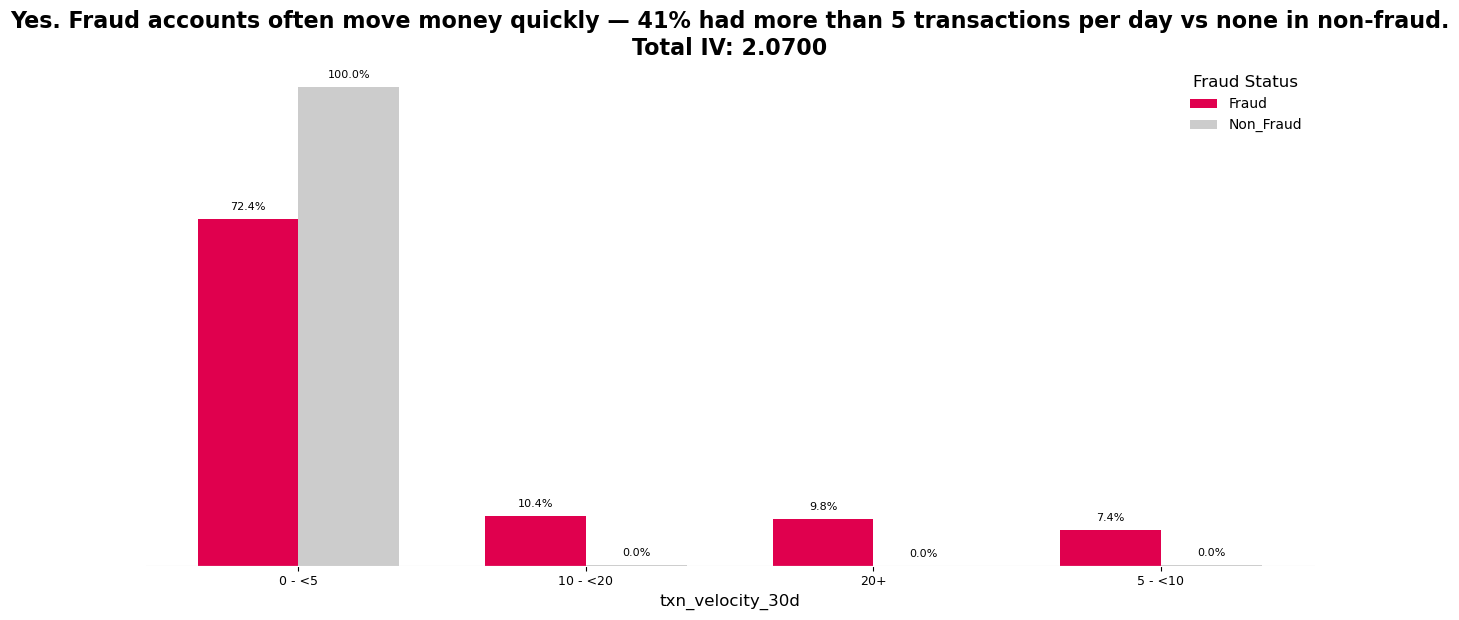

In [26]:
feature = "txn_velocity_30d"
category = "Fund Flow Patterns"
plot_feature_distribution(feature, category, REPORTS_FIGURES_DIR,
                title="Yes. Fraud accounts often move money quickly — 41% had more than 5 transactions per day vs none in non-fraud.")

##### Transaction Volatility

Plot saved to: reports\figures\4.0_txn_count_day_volatility_30d_fraud_distribution.png


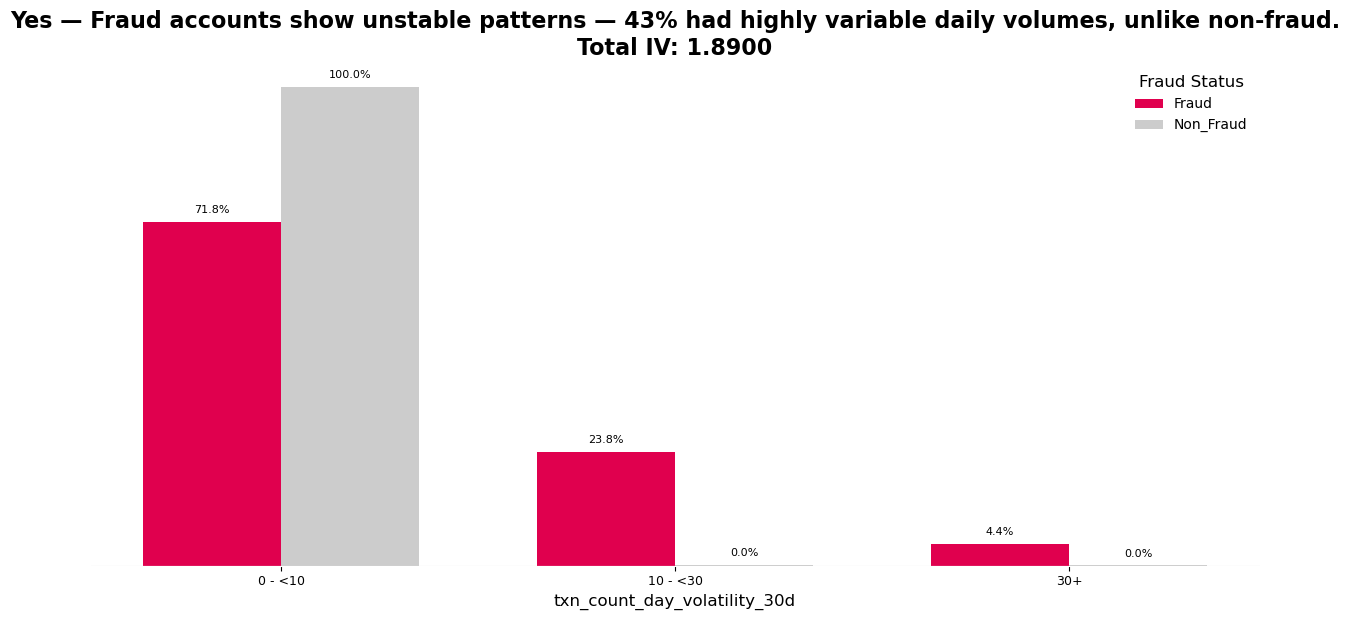

In [27]:
feature = "txn_count_day_volatility_30d"
category = "Fund Flow Patterns"
plot_feature_distribution(feature, category, REPORTS_FIGURES_DIR,
                title="Yes — Fraud accounts show unstable patterns — 43% had highly variable daily volumes, unlike non-fraud.")

# Summary of Key Findings & Fraud Profile

Our detailed EDA on the final feature set reveals a distinct profile for fraudulent accounts. Key indicators include:

- **Anomalous Account Behavior:** Fraudulent accounts are significantly more likely to use `Virtual Cards`, transact through `Android OS`, and exhibit a higher frequency of `email or mobile number changes`.
- **High-Velocity Fund Movement:** They are characterized by large transaction amounts (both `inflow` and `outflow`), high transaction `velocity`, and significant `volatility` in daily transaction counts.
- **Unusual Network Patterns:** Fraudsters tend to interact with a much larger number of `unique destination accounts` and show more `erratic` (less repetitive) transaction patterns.
- **Atypical Timing:** A strong signal of fraud is a high volume of transactions occurring during `night hours` or on `weekends`.

# Next Steps: Model Development

With a clear understanding of the key predictive features and their relationship with fraud, the project is now ready to proceed to the modeling phase. The next notebook, `5.0-mjv-model-training-and-evaluation.ipynb`, will focus on building, tuning, and evaluating a machine learning model using this prepared dataset to create an effective fraud detection system.